In [1]:
import pandas as pd
merged_df = pd.read_csv('Merged_DatasetV2.csv')
merged_df.head()

<ipython-input-1-d1843afa6d51>:2: DtypeWarning: Columns (7,14,15,16,17) have mixed types. Specify dtype option on import or set low_memory=False.
  merged_df = pd.read_csv('Merged_DatasetV2.csv')


,Unnamed: 0,id,type,type-id,score,name,address,coordinates,area,life-span,...,aliases,latitude,longitude,city,state,county,country,lifespan_years,status,services_offered
0,0,f9a1fd95-4c6d-43a6-bb31-4ee8d5a44a8b,Studio,05fa6a09-ff92-3d34-bdbb-5141d3c24f38,100,Columbia (CBS) Studio ‘B’,"49 East 52nd Street, Manhattan, New York City","{'latitude': '40.759164', 'longitude': '-73.97...","{'id': '74e50e58-5deb-4b99-93a2-decbb365c07f',...",{'ended': None},...,NaN,40.759164,-73.974123,Test Restaurant,New York,NaN,US,NaN,Active,NaN
1,1,42e9fa7c-a981-44f9-943c-bf39a8c6ce8d,Venue,cd92781a-a73f-30e8-a430-55d7521338db,100,New Theatre Oxford,"George St, Oxford OX1 2AG","{'latitude': '51.753951', 'longitude': '-1.260...","{'id': '33587495-c775-4483-b819-931c4cf438cd',...",{'ended': None},...,NaN,51.753951,-1.260011,Victoria House Hotel,England,Oxfordshire,GB,NaN,Active,NaN
2,2,34e7351d-715d-4b20-a5d6-3c0bd717eb1d,Religious building,a120ca4a-69e9-3c0e-bc09-21cae26eb621,100,Santuario della Beata Vergine di Ariadello,NaN,"{'latitude': '45.316087', 'longitude': '9.8651...","{'id': '686e7b1e-613f-419c-bcc1-1e84df36586a',...","{'begin': '1666', 'ended': None}",...,NaN,45.316087,9.865165,Genivolta,NaN,NaN,IT,359.0,Active,NaN
3,3,0ad32768-514b-410f-9d5a-40ebb0c3373c,Studio,05fa6a09-ff92-3d34-bdbb-5141d3c24f38,100,ROKU-st,〒106-0032 東京都港区六本木 3-4-24 六本木足立ビルB1F,"{'latitude': '35.664122', 'longitude': '139.72...","{'id': 'd9fd27ac-b36f-492b-b598-039ee0dd08c1',...",{'ended': None},...,"[{'sort-name': 'Roku Studio', 'type-id': 'fb68...",35.664122,139.729426,Tenso Jinja,NaN,NaN,JP,NaN,Active,NaN
4,4,0b050655-48da-4be7-b5de-7a3ee7370b9e,Venue,cd92781a-a73f-30e8-a430-55d7521338db,100,Rätschenmühle,"Schlachthausstraße 22, 73312 Geislingen/Steige","{'latitude': '48.627518', 'longitude': '9.8256...","{'id': '4518c94c-b6ee-40d0-b4b6-fc27b06fa011',...",{'ended': None},...,NaN,48.627518,9.825691,Geislingen an der Steige,NaN,NaN,DE,NaN,Active,NaN


In [2]:
# Drop rows where 'services_offered' is null
merged_df = merged_df.dropna(subset=['services_offered'])

# Drop the specified columns
merged_df = merged_df.drop(columns=['Unnamed: 0', 'id', 'name'])

# Display the updated dataframe
merged_df.head()

# Ensure the column is string type and split by commas (handling spaces)
merged_df['services_offered'] = merged_df['services_offered'].astype(str).str.split(r',\s*')

# Explode the dataframe to have one service per row
merged_df = merged_df.explode('services_offered')

# Trim any leading or trailing spaces (just in case)
merged_df['services_offered'] = merged_df['services_offered'].str.strip()

# Drop any empty values that might have been created
merged_df = merged_df[merged_df['services_offered'].notna() & (merged_df['services_offered'] != '')]

# Reset index after exploding
merged_df = merged_df.reset_index(drop=True)

import re

# Function to remove the last word and underscore
def remove_last_part(text):
    return re.sub(r'_[^_]+$', '', text)  # Removes the last underscore and the word after it

# Apply the function to the column
merged_df['services_offered'] = merged_df['services_offered'].astype(str).apply(remove_last_part)

# Display the cleaned column
print(merged_df['services_offered'].unique())

def impute_df(df):
    # Fill non-numeric columns with "Missing"
    cols_to_fill = df.columns.difference(['lifespan_years'])
    df[cols_to_fill] = df[cols_to_fill].fillna("Missing")

    # Create missing indicator for 'lifespan_years'
    df['lifespan_years_missing'] = df['lifespan_years'].isnull().astype(int)

    # Impute missing values in 'lifespan_years' with the median value
    median_val = df['lifespan_years'].median()
    df['lifespan_years'] = df['lifespan_years'].fillna(median_val)

    return df


['recorded at' 'engineered at' 'edited at' 'mixed at' 'video shot at'
 'lyrics written at' 'produced at' 'premiere' 'written at' 'commissioned'
 'composed at' 'arranged at' 'dedication' 'revised at' 'remixed at']


In [3]:
from sklearn.model_selection import train_test_split


train_df, test_df = train_test_split(merged_df, test_size=0.2, random_state=42)


train_df = impute_df(train_df)
test_df = impute_df(test_df)

In [4]:
import xgboost as xgb
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score

# Assume train_df and test_df are already loaded.

# Transform your training data as before.
X_train = pd.get_dummies(train_df.drop(columns=["services_offered", "lifespan_years"]), drop_first=True)
X_train["lifespan_years"] = train_df["lifespan_years"]
X_train.columns = X_train.columns.astype(str).str.replace(r"[,\[\]<>]", "_", regex=True)

# Similarly, transform the test data.
X_test = pd.get_dummies(test_df.drop(columns=["services_offered", "lifespan_years"]), drop_first=True)
X_test["lifespan_years"] = test_df["lifespan_years"]
X_test.columns = X_test.columns.astype(str).str.replace(r"[,\[\]<>]", "_", regex=True)

# Reindex X_test to have the same columns as X_train, filling missing columns with zeros.
X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

# Encode the target variable.
le = LabelEncoder()
y_train = le.fit_transform(train_df["services_offered"])
y_test = le.fit_transform(test_df["services_offered"])

In [5]:
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_validate

best_params = {
    "learning_rate": 0.2,
    "max_depth": 3,
    "n_estimators": 100,
    "subsample": 1.0,
    "colsample_bytree": 1.0,
    "random_state": 42
}

final_model = xgb.XGBClassifier(**best_params)

final_model.fit(X_train, y_train, verbose=False)

y_pred = final_model.predict(X_test)

# Evaluate model
f1 = f1_score(y_test, y_pred, average="macro")
print(f"Final Model Macro F1 Score on Test Set: {f1:.4f}")

Final Model Macro F1 Score on Test Set: 0.0780


SHAP

In [6]:
import shap
import xgboost as xgb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score

X_train.columns = X_train.columns.astype(str).str.replace(r"[,\[\]<>]", "_", regex=True)
X_test.columns = X_test.columns.astype(str).str.replace(r"[,\[\]<>]", "_", regex=True)

# Ensure all feature columns are numeric
X_train = X_train.apply(pd.to_numeric, errors='coerce')
X_test = X_test.apply(pd.to_numeric, errors='coerce')


In [9]:
sample_size = min(1000, len(X_train))
X_sample = X_train.sample(n=sample_size, random_state=42)

# Compute SHAP
explainer = shap.TreeExplainer(final_model)
shap_values = explainer(X_sample)

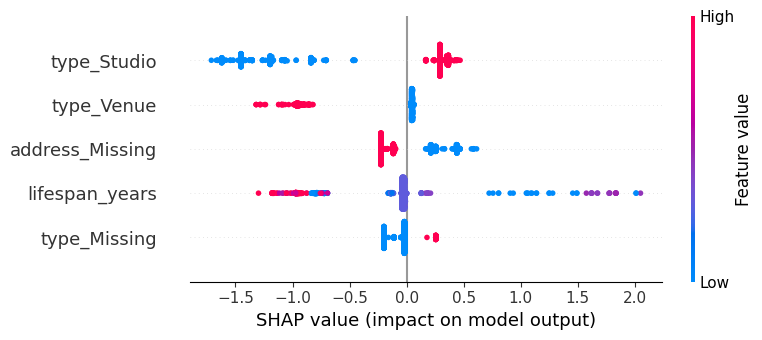

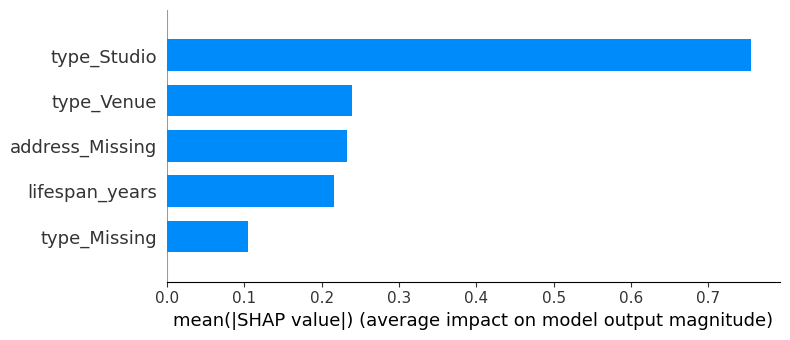

✅ Most Important Feature: type_Studio (Index 13)
SHAP Values Shape: (1000, 33334)
X_sample Shape: (1000, 33334)


In [18]:
if isinstance(shap_values.values, list) or len(shap_values.shape) == 3:
    class_index = 0  # Choose the first class
    shap_values_array = shap_values.values[:, :, class_index]  # Extract SHAP values for class 0
else:
    shap_values_array = shap_values.values  # Binary classification case

# 🔹 Fix SHAP Shape Issue
if shap_values_array.shape[1] == 1:
    print(f"SHAP values only have {shap_values_array.shape[1]} feature(s). Expanding...")
    shap_values_array = shap_values_array.reshape(-1, X_sample.shape[1])  # Reshape if needed

# 🔹 Ensure X_sample and SHAP Values Match
num_features_shap = shap_values_array.shape[1]
num_features_X = X_sample.shape[1]

if num_features_shap != num_features_X:
    print(f"SHAP values have {num_features_shap} features, but X_sample has {num_features_X}. Adjusting...")
    X_sample = X_sample.iloc[:, :num_features_shap]  # Trim X_sample to match SHAP

# 🔹 SHAP Summary Plot (Beeswarm)
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values_array, X_sample, feature_names=X_sample.columns, max_display=5)

# 🔹 SHAP Feature Importance Bar Plot
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values_array, X_sample, feature_names=X_sample.columns, plot_type="bar", max_display= 5)

# 🔹 Select Most Important Feature for Dependence Plot
most_important_feature_index = np.argmax(np.abs(shap_values_array).mean(axis=0))

# 🔹 Ensure Index is Valid
most_important_feature_index = min(most_important_feature_index, shap_values_array.shape[1] - 1)
most_important_feature = X_sample.columns[most_important_feature_index]

print(f"✅ Most Important Feature: {most_important_feature} (Index {most_important_feature_index})")
print(f"SHAP Values Shape: {shap_values_array.shape}")
print(f"X_sample Shape: {X_sample.shape}")